# Notebook 1: Neural ODE 2D Classification

Este notebook implementa e treina Neural ODEs para classificação em dados 2D.

## Objetivos:
1. Implementar VectorField e NeuralODE com classificação
2. Treinar em dataset 2D sintético (moons, circles, spirals)
3. Visualizar trajetórias a partir de dados do dataset (x(0) → x(1))
4. Visualizar transformações a partir de z ~ N(0,I) (z(0) → x(1))
5. Visualizar vector fields
6. Analisar NFEs e comparar solvers


In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import torch
import torch.optim as optim
from src.models.neural_ode import NeuralODE
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, get_dataloader
from src.utils.training import train_neural_ode, count_nfe
from src.utils.visualization import (
    plot_data_distribution,
    plot_trajectories,
    plot_transformation,
    plot_vector_field,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 1. Carregar Dataset


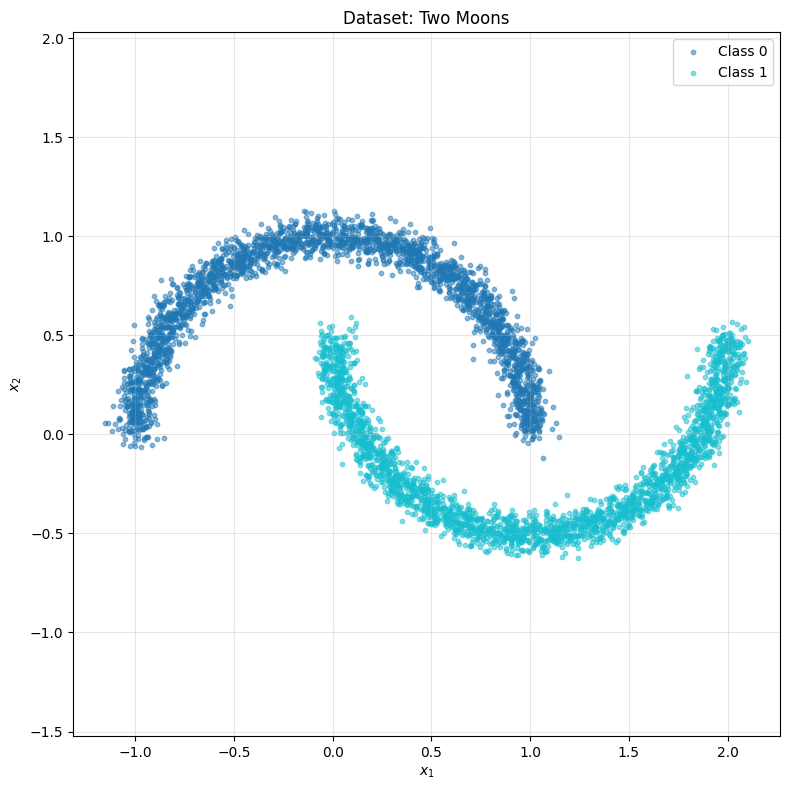

Dataset size: 5000
Number of classes: 2


In [2]:
# Criar dataset (moons, circles, ou spirals - todos têm 2 classes)
dataset = Synthetic2D(n_samples=5000, noise=0.05, dataset_type='moons')
dataloader = get_dataloader(dataset, batch_size=128, shuffle=True)

# Visualizar dados com cores por classe
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_data_distribution(
    dataset.data,
    labels=dataset.labels,
    ax=ax,
    title="Dataset: Two Moons"
)
plt.tight_layout()
plt.show()

print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {len(torch.unique(dataset.labels))}")


## 2. Criar e Treinar Modelo


In [3]:
# Criar modelo com classificação (2 classes para moons/circles/spirals)
vf = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
model = NeuralODE(
    vf,
    solver='dopri5',
    rtol=1e-3,
    atol=1e-4,
    num_classes=2  # 2 classes para datasets sintéticos
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Treinar para classificação
train_neural_ode(model, dataloader, optimizer, device, num_epochs=5)


Epoch 1/5: 100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


Epoch 1, Loss: 0.536183, Accuracy: 78.46%


Epoch 2/5: 100%|██████████| 40/40 [00:02<00:00, 14.33it/s]


Epoch 2, Loss: 0.278395, Accuracy: 86.72%


Epoch 3/5: 100%|██████████| 40/40 [00:02<00:00, 15.71it/s]


Epoch 3, Loss: 0.192088, Accuracy: 91.82%


Epoch 4/5: 100%|██████████| 40/40 [00:02<00:00, 15.56it/s]


Epoch 4, Loss: 0.130832, Accuracy: 95.46%


Epoch 5/5: 100%|██████████| 40/40 [00:02<00:00, 15.07it/s]


Epoch 5, Loss: 0.057064, Accuracy: 99.04%


0.057064022542908786

## 3. Visualizar Trajetórias


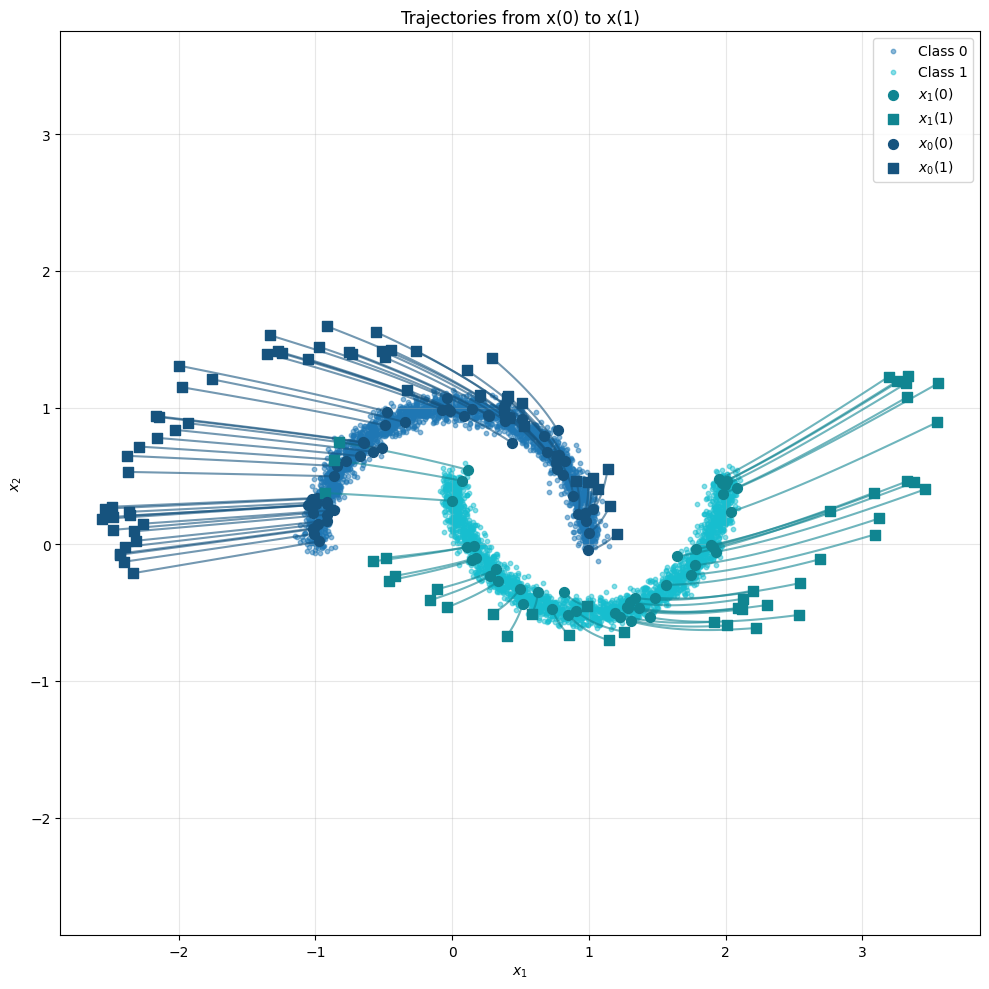

In [4]:
# Plotar trajetórias a partir de amostras do dataset
# Mostra x(0) → x(1) onde x(0) são pontos do dataset
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Primeiro, plotar a distribuição alvo para referência (com cores por classe)
plot_data_distribution(
    dataset.data,
    labels=dataset.labels,
    ax=ax,
    title="Trajectories from Dataset Samples (x(0) → x(1))"
)

# Depois, plotar as trajetórias a partir de amostras aleatórias do dataset
plot_trajectories(model, dataset, n_samples=100, ax=ax)
plt.tight_layout()
plt.show()


## 4. Visualizar Vector Field


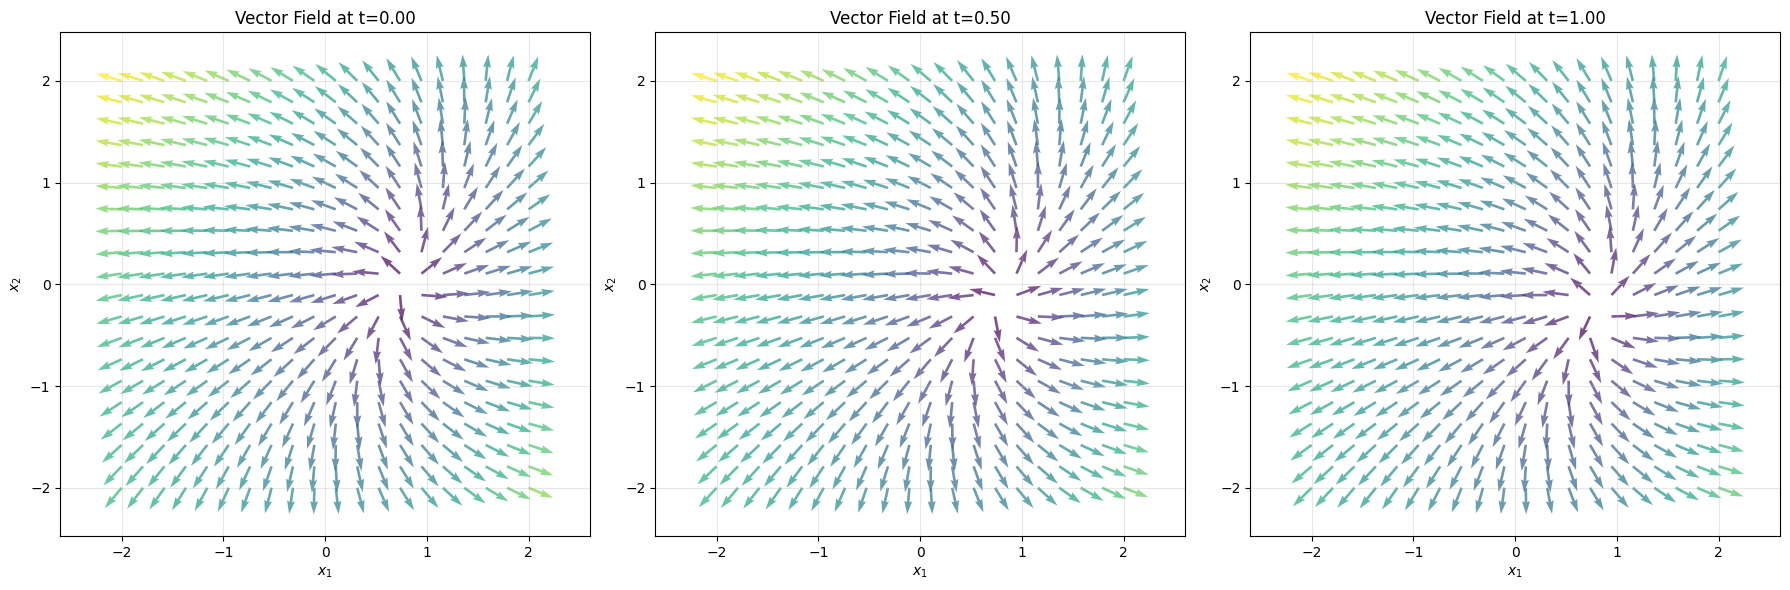

In [6]:
# Plotar vector field em diferentes tempos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    plot_vector_field(
        model,
        xlim=(-2, 2),
        ylim=(-2, 2),
        n_grid=20,
        t=t,
        ax=axes[i]
    )
plt.tight_layout()
plt.show()


## 5. Visualizar Transformação


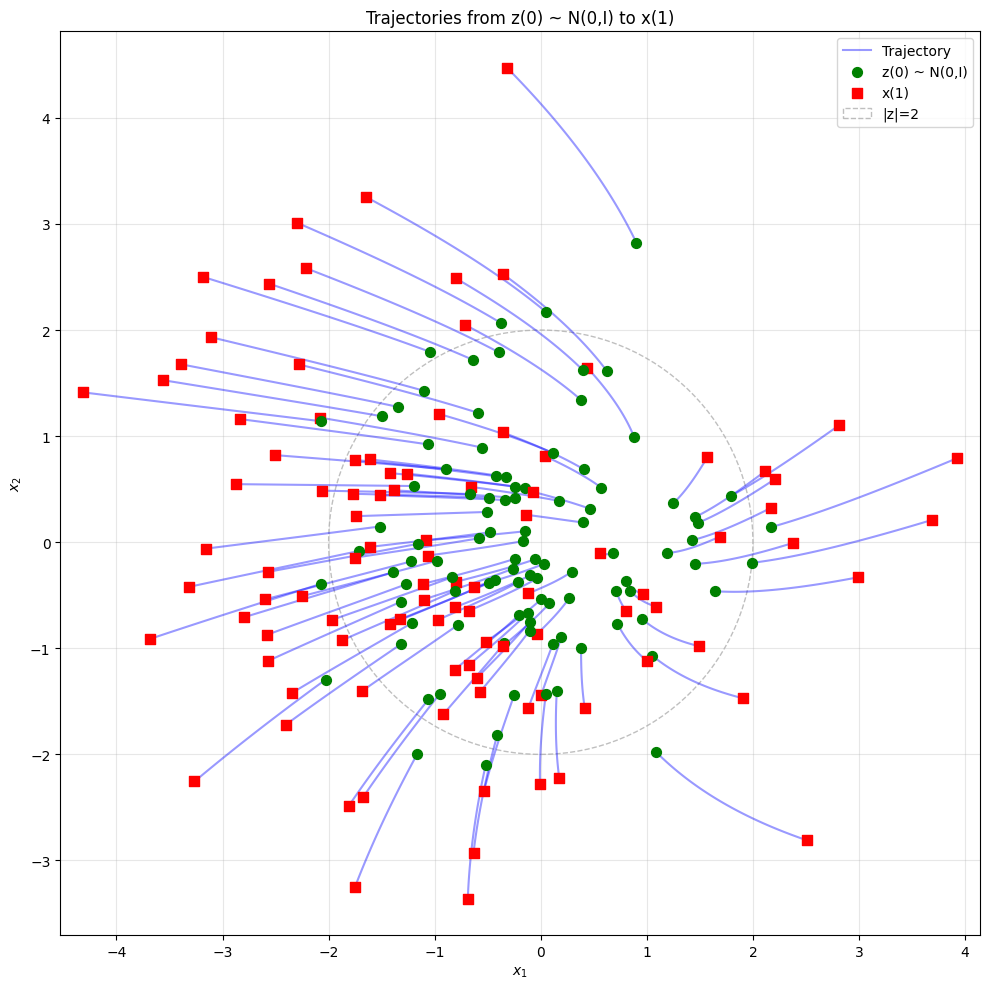

In [12]:
# Mostra trajetórias completas de z(0) ~ N(0,I) até x(1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_transformation(
    model,
    n_samples=100,
    n_trajectory_points=100,
    ax=ax
)
plt.tight_layout()
plt.show()


## 6. Analisar NFEs (Number of Function Evaluations)


In [13]:
# Comparar diferentes solvers
solvers = ['euler', 'rk4', 'dopri5']
nfe_results = {}

# Usar amostras de N(0, I) para contagem de NFEs
sample_batch = torch.randn(10, 2).to(device)

print("=== Comparação de Solvers ===")
for solver in solvers:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver=solver,
        rtol=1e-3,
        atol=1e-4,
        num_classes=2  # Necessário para classificação
    ).to(device)
    # Copiar apenas os pesos do vector field (não do classifier)
    model_test.vf.load_state_dict(model.vf.state_dict())
    if model.classifier is not None:
        model_test.classifier.load_state_dict(model.classifier.state_dict())

    nfe = count_nfe(model_test, sample_batch)
    nfe_results[solver] = nfe
    print(f"{solver}: {nfe} NFEs")

# Comparar diferentes tolerâncias
tolerances = [(1e-2, 1e-3), (1e-3, 1e-4), (1e-4, 1e-5)]
nfe_tol_results = {}

print("\n=== Comparação de Tolerâncias (dopri5) ===")
for rtol, atol in tolerances:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver='dopri5',
        rtol=rtol,
        atol=atol,
        num_classes=2
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    if model.classifier is not None:
        model_test.classifier.load_state_dict(model.classifier.state_dict())

    nfe = count_nfe(model_test, sample_batch)
    nfe_tol_results[(rtol, atol)] = nfe
    print(f"rtol={rtol}, atol={atol}: {nfe} NFEs")


=== Comparação de Solvers ===
euler: 99 NFEs
rk4: 396 NFEs
dopri5: 14 NFEs

=== Comparação de Tolerâncias (dopri5) ===
rtol=0.01, atol=0.001: 14 NFEs
rtol=0.001, atol=0.0001: 14 NFEs
rtol=0.0001, atol=1e-05: 20 NFEs
